Total rânduri după concatenare: 936085

Valori lipsă pe coloane:
SEX           3
AGE           1
EDUCSTAT      0
DEGURBA     449
STAPRO      294
TEMP          0
FTPT          0
COURATT       1
ILOSTAT       0
dtype: int64

Rânduri rămase după curățare: 935366

Distribuția șomajului (target):
ILOSTAT
0    907500
1     27866
Name: count, dtype: int64

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    181501
           1       0.66      0.19      0.30      5573

    accuracy                           0.97    187074
   macro avg       0.82      0.59      0.64    187074
weighted avg       0.97      0.97      0.97    187074


=== Confusion Matrix ===
[[180937    564]
 [  4502   1071]]

=== ROC-AUC Score: 0.9619 ===


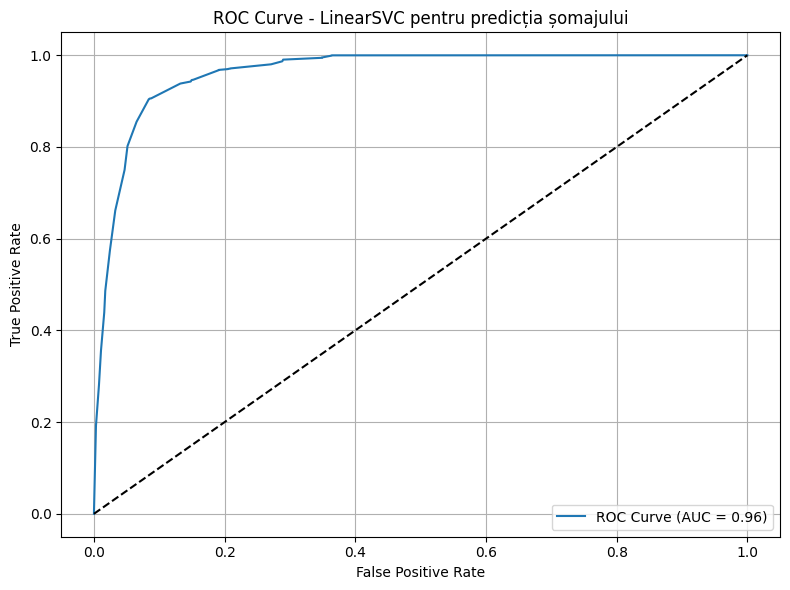

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

# === 1. Încarcă datele pentru toți anii ===
years = ['2010', '2011', '2012', '2013']
dfs = []
for year in years:
    df = pd.read_csv(f"../data/raw/RO_LFS_{year}_Y.csv", low_memory=False)
    df['YEAR'] = int(year)
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)
print(f"Total rânduri după concatenare: {data.shape[0]}")

# === 2. Selectează variabilele ===
features = ['SEX', 'AGE', 'EDUCSTAT', 'DEGURBA', 'STAPRO', 'TEMP', 'FTPT', 'COURATT']
target = 'ILOSTAT'

data = data[features + [target]].copy()

# === 3. Creează target binary ===
data = data[data[target].notna()]
data[target] = (data[target] == 2).astype(int)

# === 4. Elimină rândurile cu date lipsă în variabilele relevante ===
print("\nValori lipsă pe coloane:")
print(data.isnull().sum())

data.dropna(subset=features + [target], inplace=True)
print(f"\nRânduri rămase după curățare: {len(data)}")

# === 5. Distribuția claselor ===
print("\nDistribuția șomajului (target):")
print(data[target].value_counts())

# === 6. One-hot encoding pentru categorice ===
data_encoded = pd.get_dummies(data, columns=features, drop_first=True)

# === 7. Train-test split ===
X = data_encoded.drop(columns=[target])
y = data_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === 8. Normalizare ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 9. LinearSVC + calibrator pentru probabilități ===
svc = LinearSVC(class_weight='balanced', max_iter=1000, random_state=42)
model = CalibratedClassifierCV(svc)
model.fit(X_train_scaled, y_train)

# === 10. Evaluare ===
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\n=== ROC-AUC Score: {roc_auc:.4f} ===")

# === 11. ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LinearSVC pentru predicția șomajului")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
